In [1]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = ''
from tqdm import tqdm
sys.path.append(os.path.abspath('..'))
import modules.io as io
import modules.vascular_data as sv
from medpy.metric.binary import dc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import tensorflow as tf

In [2]:
DATA_KEY    = "TEST"
CONFIG_FILE = '../config/uq/googlenet_c30_train300k_aug10_clean_uq1.yaml'
#CONFIG_FILE = '../config/unet_c30_train300k_aug10_clean.yaml'
LOAD = True

config      = io.load_yaml(CONFIG_FILE)
config['MODEL_DIR'] = config['MODEL_DIR'].replace('.','..')
#config['DROPOUT'] = 0.1

SCALE = config['CROP_DIMS']/2*config['SPACING']

In [3]:
import factories.dataset_factory as dataset_factory

data    = dataset_factory.get(config, DATA_KEY)

392it [00:00, 3919.50it/s]

centering images


3788it [00:00, 3846.09it/s]
 47%|████▋     | 1787/3788 [00:20<00:23, 86.41it/s]

outlier


 59%|█████▉    | 2244/3788 [00:25<00:17, 88.65it/s]

outlier


100%|██████████| 3788/3788 [00:42<00:00, 89.15it/s]


In [4]:
import factories.model_factory as model_factory

model = model_factory.get(config)
if LOAD: model.load()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




pool 1 Tensor("googlenet/max_pool:0", shape=(?, 79, 79, 64), dtype=float32)
pool_2 Tensor("googlenet/max_pool_1:0", shape=(?, 39, 39, 192), dtype=float32)
pool 3 Tensor("googlenet/max_pool_2:0", shape=(?, 19, 19, 480), dtype=float32)
pool side Tensor("googlenet/avg_pool:0", shape=(?, 5, 5, 833), dtype=float32)
[None, 3200]

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[None, 1024]
pool 5 Tensor("googlenet/max_pool_3:0", shape=(?, 9, 9, 833), dtype=float32)
pool final Tensor("googlenet/avg_pool_1:0", shape=(?, 3, 3, 1024), dtype=float32)
[None, 9216]
[None, 

In [ ]:
tensor_list = [n.name for n in tf.get_default_graph().as_graph_def().node]
for t in tensor_list:
    print(t)

Placeholder
Placeholder_1
googlenet/input_7x7/random_normal/shape
googlenet/input_7x7/random_normal/mean
googlenet/input_7x7/random_normal/stddev
googlenet/input_7x7/random_normal/RandomStandardNormal
googlenet/input_7x7/random_normal/mul
googlenet/input_7x7/random_normal
googlenet/input_7x7/W
googlenet/input_7x7/W/Assign
googlenet/input_7x7/W/read
googlenet/input_7x7/zeros
googlenet/input_7x7/b
googlenet/input_7x7/b/Assign
googlenet/input_7x7/b/read
googlenet/input_7x7/convolution
googlenet/input_7x7/add
googlenet/input_7x7/leaky_re_lu/LeakyRelu
googlenet/max_pool/dilation_rate
googlenet/max_pool
googlenet/input_1x1_r/random_normal/shape
googlenet/input_1x1_r/random_normal/mean
googlenet/input_1x1_r/random_normal/stddev
googlenet/input_1x1_r/random_normal/RandomStandardNormal
googlenet/input_1x1_r/random_normal/mul
googlenet/input_1x1_r/random_normal
googlenet/input_1x1_r/W
googlenet/input_1x1_r/W/Assign
googlenet/input_1x1_r/W/read
googlenet/input_1x1_r/zeros
googlenet/input_1x1_r/b


gradients/googlenet/inception_4c/3x3/convolution_grad/tuple/control_dependency
gradients/googlenet/inception_4c/3x3/convolution_grad/tuple/control_dependency_1
gradients/googlenet/inception_4c/5x5/convolution_grad/ShapeN
gradients/googlenet/inception_4c/5x5/convolution_grad/Conv2DBackpropInput
gradients/googlenet/inception_4c/5x5/convolution_grad/Conv2DBackpropFilter
gradients/googlenet/inception_4c/5x5/convolution_grad/tuple/group_deps
gradients/googlenet/inception_4c/5x5/convolution_grad/tuple/control_dependency
gradients/googlenet/inception_4c/5x5/convolution_grad/tuple/control_dependency_1
gradients/googlenet/inception_4c/1x1_pool/convolution_grad/ShapeN
gradients/googlenet/inception_4c/1x1_pool/convolution_grad/Conv2DBackpropInput
gradients/googlenet/inception_4c/1x1_pool/convolution_grad/Conv2DBackpropFilter
gradients/googlenet/inception_4c/1x1_pool/convolution_grad/tuple/group_deps
gradients/googlenet/inception_4c/1x1_pool/convolution_grad/tuple/control_dependency
gradients/goog

In [ ]:
import factories.preprocessor_factory as prepro_factory

preprocessor = prepro_factory.get(config)

In [ ]:
import factories.postprocessor_factory as postpro_factory

postprocessor = postpro_factory.get(config)

In [ ]:
X = np.array([preprocessor(x) for x in data[0]])
print(X.shape)

(3786, 160, 160, 1)


In [ ]:
op = tf.get_default_graph().get_tensor_by_name("googlenet/dropout/random_uniform:0")
print(op)

Tensor("googlenet/dropout/random_uniform:0", shape=(?, 1024), dtype=float32)


In [ ]:
out = model.sess.run(op, {model.x:X[0][np.newaxis,:,:,:]})
print(out.shape)
print(out[:10])

(1, 1024)
[[0.97788715 0.32159007 0.07006991 ... 0.9415345  0.19620347 0.5694004 ]]


In [ ]:
INDEX = 1
N = 100
#model.sample()
contours = []
for i in range(N):
    yhat = model.predict(X[INDEX])
    c    = postprocessor(yhat)
    contours.append(c)

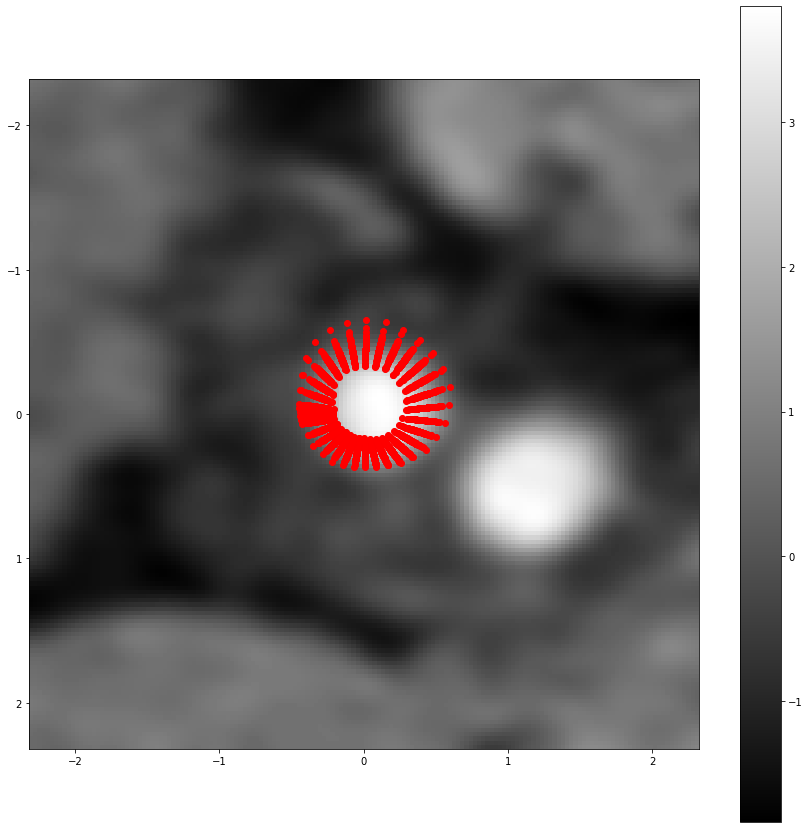

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(X[INDEX,:,:,0], extent=[-SCALE, SCALE, SCALE, -SCALE], cmap='gray')
for c in contours:
    plt.plot(c[:,0], c[:,1], color='r', marker='o', linestyle='')
plt.colorbar()
plt.show()

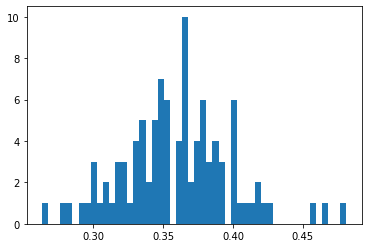

In [ ]:
radiuses = []
for c in contours:
    cc = c-np.mean(c,axis=0)
    rs = np.sqrt(np.sum(cc**2,axis=1))
    r  = np.mean(rs)
    radiuses.append(r)

plt.figure()
plt.hist(radiuses, bins=50, label='radius')
plt.show()

In [ ]:
Nx = X.shape[0]
Nc = 40
C  = np.zeros((Nx,Nc,34,2))

In [ ]:
for i in tqdm(range(X.shape[0])):
    for j in range(Nc):
        yhat = model.predict(X[i])
        c    = postprocessor(yhat)
    
        cc = c-np.mean(c,axis=0)
        C[i,j] = cc

 23%|██▎       | 854/3786 [11:39<39:23,  1.24it/s]

In [ ]:
Cbar = np.mean(C,axis=1)

In [ ]:
W = 160
SPACING = 0.029
ORIGIN = 0

dice = []
rads = []

for i in range(Nx):
    ct = Cbar[i]
    for j in range(Nc):
        c = C[i,j]


        seg   = sv.contourToSeg(c,[ORIGIN]*2,[W]*2,[SPACING]*2)
        seg_t = sv.contourToSeg(ct,[ORIGIN]*2,[W]*2,[SPACING]*2)

        r = np.sqrt(np.sum(seg)*1.0/np.pi)*SPACING
        d = dc(seg,seg_t)

        rads.append(r)
        dice.append(d)

rads = np.array(rads)
dice = np.array(dice)

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(rads,dice,marker='o',linestyle='')
plt.xlabel('radius cm')
plt.ylabel('dice')
plt.show()

In [ ]:
inds = rads < 0.4
ds = dice[inds]
print(np.mean(ds))
print(np.std(ds))

In [ ]:
inds = rads > 0.4
ds = dice[inds]
print(np.mean(ds))
print(np.std(ds))